In [1]:
import yt
from yt import YTArray
from yt import YTQuantity

from astropy import constants as const

import numpy as np

import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.colors import SymLogNorm, LogNorm

import palettable
import plotting_tools as pt
import yt_functions as ytf


yt : [INFO     ] 2019-10-28 07:57:24,159 Parameters: current_time              = 0
yt : [INFO     ] 2019-10-28 07:57:24,161 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-10-28 07:57:24,161 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-10-28 07:57:24,162 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-10-28 07:57:24,163 Parameters: cosmological_simulation   = 0.0


In [25]:
def _crenergy(field, data):
    crenergy_denstiy = data[('enzo', 'CREnergyDensity')]
    rho = data[('enzo', 'Density')]
    return YTArray(crenergy_density / rho, 'code_velocity**2')

def doit(ds, field = 'drho'):
    dims = ds.domain_dimensions
    nx, ny, nz = dims

    Kk = np.zeros( (nx//2+1, ny//2+1, nz//2+1))
    Kk = fft_comp(ds, field)

    # wavenumbers in units of box length
    L = np.array([1.0, 1.0, 1.0])
    
    kx = np.fft.rfftfreq(nx)*nx/L[0]
    ky = np.fft.rfftfreq(ny)*ny/L[1]
    kz = np.fft.rfftfreq(nz)*nz/L[2]

    # physical limits to the wavenumbers
    kmin = np.min(1.0/L)
    kmax = np.min(0.5*np.array(dims)/L)
    
    
    kbins = np.arange(kmin, kmax, kmin)
    N = len(kbins)

    # bin the Fourier KE into radial kbins
    kx3d, ky3d, kz3d = np.meshgrid(kx, ky, kz, indexing="ij")
    k = np.sqrt(kx3d**2 + ky3d**2 + kz3d**2)

    whichbin = np.digitize(k.flat, kbins)
    ncount = np.bincount(whichbin)

    P_spectrum = np.zeros(len(ncount)-1)

    for n in range(1,len(ncount)):
        P_spectrum[n-1] = np.sum(Kk.flat[whichbin==n])

    #k = 0.5*(kbins[0:N-1] + kbins[1:N])
    k = kbins[1:N]
    P_spectrum = P_spectrum[1:N]
    return k, P_spectrum


def fft_comp(ds, field, level = 0 ):
    cube = ds.covering_grid(level, left_edge=ds.domain_left_edge,
                            dims=ds.domain_dimensions)

    rho = cube[('gas', 'density')].d        
    if field == 'rho':
        fft_field = rho
    elif field == 'drho':
        drho = np.ndarray(shape = rho.shape)
        for i in range(len(rho)):
            rho_slice = rho[:, :, i] 
            rho_ave = np.mean(rho_slice)
            drho[:, :, i]  = (rho_slice - rho_ave) / rho_ave
        fft_field = drho

    nx, ny, nz = rho.shape

    # do the FFTs -- note that since our data is real, there will be
    # too much information here.  fftn puts the positive freq terms in
    # the first half of the axes -- that's what we keep.  Our
    # normalization has an '8' to account for this clipping to one
    # octant.
        
    ru = np.fft.fftn(fft_field)[0:nx//2+1,0:ny//2+1,0:nz//2+1]
    ru = 8.0*ru/(nx*ny*nz)

    return np.abs(ru)**2


def plot_power_spectrum(field, output_list = [0], model = 'isothermal', tctf_list = [1], \
                        beta_list = ['inf'], k = 4, label_list = None, \
                        work_dir = '../../simulations'):

    fig, ax = plt.subplots(figsize = (6, 6))
    
    if label_list == None:
        label_list = tctf_list
    for output, tctf, beta, label in zip(output_list, tctf_list, beta_list, label_list):
        # load the simulation
        sim_loc = '%s/%s_tctf_%.1f'%(work_dir, model, tctf)
        if beta != 'inf':
            sim_loc += '_beta_%.1f'%(beta)
            if beta == 256:
                sim_loc += '_k_%.1f'%(k)
        ds = yt.load('%s/DD%04d/DD%04d'%(sim_loc, output, output))
        
        k, P_k = doit(ds, field)
        ax.loglog(k, P_k, label = label, linewidth = 3)
     
    ax.axvline(3.28, color = 'black', linestyle = 'dashed')
    ax.set_xlabel('k')
    ax.set_ylabel('P(k)')
    ax.set_xlim(1, 1e2)
    ax.set_ylim(1e-6, 1e2)
    ax.legend()
    fig.tight_layout()
    plt.show()
    


yt : [INFO     ] 2019-10-28 08:15:07,090 Parameters: current_time              = 0
yt : [INFO     ] 2019-10-28 08:15:07,091 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-10-28 08:15:07,092 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-10-28 08:15:07,093 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-10-28 08:15:07,094 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-10-28 08:15:07,099 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2019-10-28 08:15:07,809 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-28 08:15:07,809 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-28 08:15:07,810 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-28 08:15:07,811 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-28 08:15:07,812 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2019-10-28 08:15:07,824 Making a fixed resolution buffer of (('gas

0


yt : [INFO     ] 2019-10-28 08:15:12,036 Making a fixed resolution buffer of (y) 800 by 800


1


yt : [INFO     ] 2019-10-28 08:15:12,455 Projection completed
yt : [INFO     ] 2019-10-28 08:15:12,462 Making a fixed resolution buffer of (z) 800 by 800
yt : [INFO     ] 2019-10-28 08:15:12,841 Projection completed
yt : [INFO     ] 2019-10-28 08:15:12,849 Making a fixed resolution buffer of (density) 800 by 800
yt : [INFO     ] 2019-10-28 08:15:13,053 Making a fixed resolution buffer of (('gas', 'pressure')) 800 by 800
yt : [INFO     ] 2019-10-28 08:15:13,303 Projection completed
/home/ibutsky/yt/yt/units/yt_array.py:1400: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)
yt : [INFO     ] 2019-10-28 08:15:14,289 Parameters: current_time              = 0
yt : [INFO     ] 2019-10-28 08:15:14,290 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-10-28 08:15:14,291 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-10-28 08:15:14,292 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-10-28

0


yt : [INFO     ] 2019-10-28 08:15:18,826 Making a fixed resolution buffer of (y) 800 by 800


1


yt : [INFO     ] 2019-10-28 08:15:19,177 Projection completed
yt : [INFO     ] 2019-10-28 08:15:19,185 Making a fixed resolution buffer of (z) 800 by 800
yt : [INFO     ] 2019-10-28 08:15:19,545 Projection completed
yt : [INFO     ] 2019-10-28 08:15:19,552 Making a fixed resolution buffer of (density) 800 by 800
yt : [INFO     ] 2019-10-28 08:15:19,759 Making a fixed resolution buffer of (('gas', 'pressure')) 800 by 800
yt : [INFO     ] 2019-10-28 08:15:19,979 Projection completed


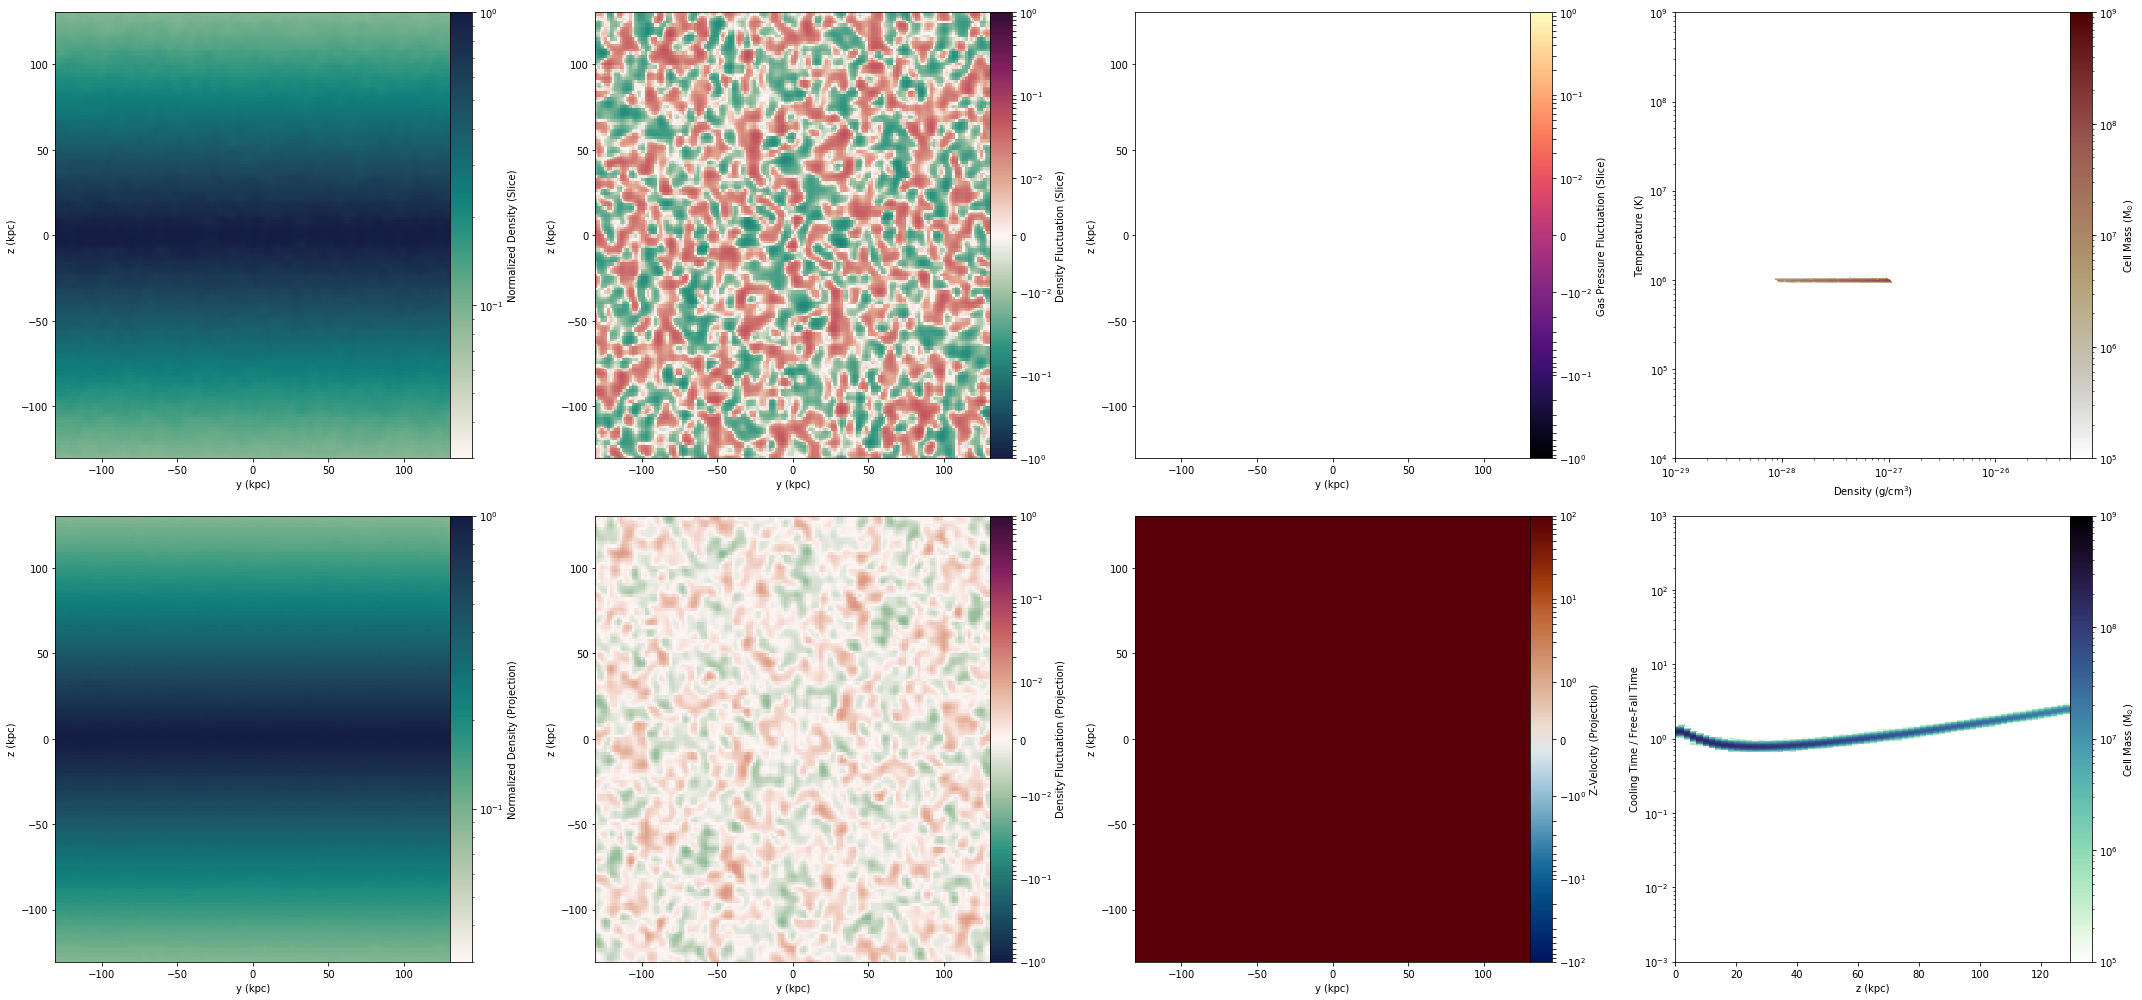

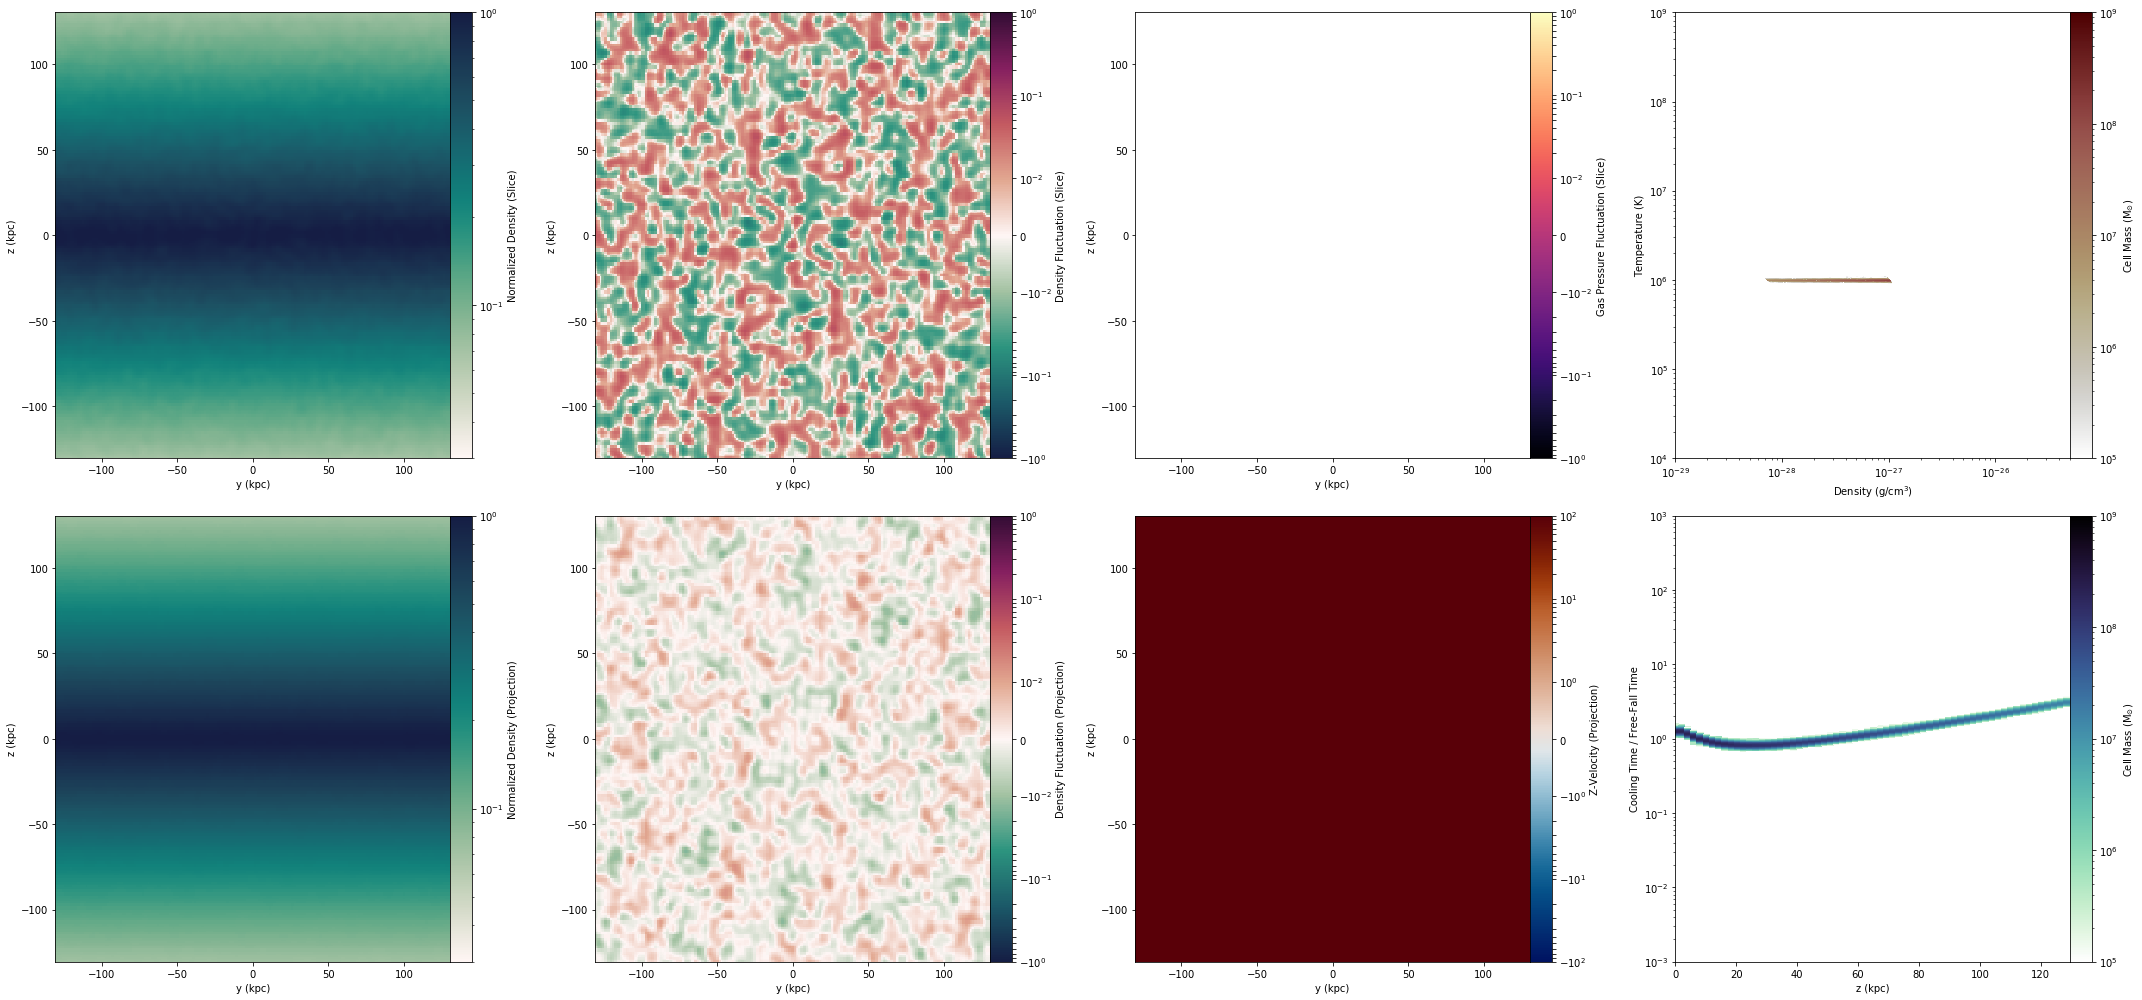

In [10]:
#folder = 'isothermal_tctf_3.0_beta_256.0_k_4.0'
folder = 'isothermal_tctf_0.1_beta_4.0'
folder = 'isothermal_tctf_1.0_beta_10.0_cr_0.1'

#folder = 'isentropic_tctf_3.0_beta_256.0_k_4.0'
#folder = 'isentropic_tctf_3.0_beta_256.0_k_32.0'

half_range = 1
rho0 = 1e-27
view = 'x'

i = 0
ds = ytf.load('../../simulations/%s/DD%04d/DD%04d'%(folder, i, i))
fig, ax = pt.plot_density_slices(ds)


folder = 'isothermal_tctf_1.0_beta_10.0'

ds = ytf.load('../../simulations/%s/DD%04d/DD%04d'%(folder, i, i))
fig, ax = pt.plot_density_slices(ds)
    
    


In [13]:
i = 0
ds = ytf.load('../../simulations/isothermal_tctf_1.0_beta_10.0_cr_0.1/DD%04d/DD%04d'%(i, i))
ad = ds.all_data()
ad[('enzo', 'CREnergyDensity')]


yt : [INFO     ] 2019-10-28 08:17:06,786 Parameters: current_time              = 0
yt : [INFO     ] 2019-10-28 08:17:06,787 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-10-28 08:17:06,788 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-10-28 08:17:06,789 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-10-28 08:17:06,790 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-10-28 08:17:06,793 Gathering a field list (this may take a moment.)


YTArray([0.18170283, 0.1889368 , 0.19645864, ..., 0.19645864, 0.1889368 ,
         0.18170283]) (dimensionless)

In [24]:
ds.field_list
ad[('enzo', 'z-velocity')]


YTArray([2.8851102 , 2.88841928, 2.90308289, ..., 3.01281512, 2.97488759,
         2.93895988]) code_velocity

yt : [INFO     ] 2019-10-17 12:43:19,651 Parameters: current_time              = 8.4999990045463
yt : [INFO     ] 2019-10-17 12:43:19,652 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-10-17 12:43:19,653 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-10-17 12:43:19,654 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-10-17 12:43:19,655 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-10-17 12:43:19,677 Gathering a field list (this may take a moment.)
/simons/scratch/ibutsky/thermal_instabilities/analysis/yt_functions.py:39: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  display_name = 'External Acceleration Z', units = 'cm/s**2')
/simons/scratch/ibutsky/thermal_instabilities/analysis/yt_functions.py:42: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  display_name = 'Free Fall Time', units = 's')
/simo


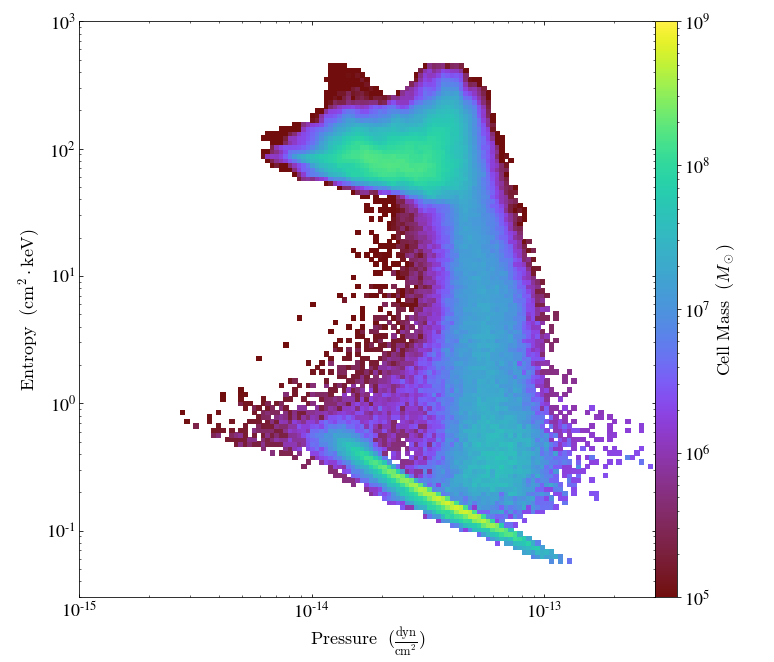

In [53]:
folder = 'isentropic_tctf_1.0'
folder = 'isothermal_tctf_1.0'
i = 85
ds = ytf.load('../../simulations/%s/DD%04d/DD%04d'%(folder, i, i))
ad = ds.all_data()

xfield = ('gas', 'pressure')
yfield = ('gas', 'entropy')
zfield = ('gas', 'cell_mass')
ph = yt.PhasePlot(ad, xfield, yfield, zfield, weight_field = None)
ph.set_unit(zfield, 'Msun')
ph.set_zlim(zfield, 1e5, 1e9)

ph.set_xlim(1e-15, 3e-13)
ph.set_ylim(3e-2, 1e3)
ph.show()

In [15]:
low = ds.domain_left_edge
dims = [128, 128, 128]
cube = ds.covering_grid(0, left_edge = ds.domain_left_edge, dims = dims, \
                        fields = [('gas', 'density'), ('gas', 'thermal_energy')])
                        

In [102]:
rho = cube[('gas', 'density')]

In [104]:
nx, ny, nz = rho.shape

In [105]:
nx

128